# Homework 1 



### Instructions
Download this jupyer notebook (button at the top of the page or download from the Github repository). Provide your answers as Markdown text, Python code, and/or produce plots as appropriate. The notebook should run all the cells in order without errors.  
Submit both the `.ipynb` and a `.pdf` to Canvas.

Make sure the `.pdf` has all the relevant outputs showing. To save as `.pdf` you can first export the notebook as `.html`, open it in a browers and then "Print to PDF". 

**NOTE:** As we will be sharing the files for peer grading, please keep your submission anonymous.

In [95]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cp
import math
from jax import grad, jit, vmap


## Problem 1
In this problem, you will familiarize yourself with the basic operations with dynamical systems and useful JAX operations.

Given the following dynamics class below.

In [96]:
class Dynamics(metaclass=abc.ABCMeta):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

### (a) Setting up dynamics
Using the `Dynamics` class, construct the continuous time dynamics for the dynamically extended unicycle model.

$$
    \dot{\mathbf{x}} = \begin{bmatrix}
        \dot{x} \\ \dot{y} \\ \dot{\theta} \\ \dot{v}
    \end{bmatrix} = \begin{bmatrix}
        v\cos\theta \\ v\sin\theta \\ \omega \\ a
    \end{bmatrix}, \qquad u=(\omega, a)
$$

In [97]:
def dynamic_unicycle_ode(state, control, time):
    x, y, theta, v = state
    omega = control[0]
    a = control[1]
    dxdt = v*jnp.cos(theta)
    dydt = v*jnp.sin(theta)
    dthetadt = omega
    dvdt = a

    return jnp.array([dxdt, dydt, dthetadt, dvdt])


state_dim = 4
control_dim = 2
continuous_dynamics = Dynamics(dynamic_unicycle_ode, state_dim, control_dim)

### (b) Obtaining discrete-time dynamics

With the continuous time dynamics, we can obtain the discrete time dynamics by integrating over a time step $\Delta t$.

Implement both Euler integation and Runge-Kutta integration to obtain the discrete-time dynamics.

In [98]:
def euler_integrate(dynamics, dt):
    # zero-order hold
    def integrator(x, u, t):
        dx = dynamics(x, u, t)
        return x + dt * dx
    return integrator


def runge_kutta_integrator(dynamics, dt=0.1):
    # zero-order hold
    def integrator(x, u, t):
        k1 = dynamics(x, u, t)
        k2 = dynamics(x + 0.5 * dt * k1, u, t + 0.5 * dt)
        k3 = dynamics(x + 0.5 * dt * k2, u, t + 0.5 * dt)
        k4 = dynamics(x + dt * k3, u, t + dt)
        return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return integrator

In [99]:
# example usage of the integrators

dt = 0.1 # timestep size

discrete_dynamics_euler = Dynamics(
    euler_integrate(continuous_dynamics, dt), state_dim, control_dim
)
discrete_dynamics_rk = Dynamics(
    runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
)

### (c) Simulating dynamics

Simulate your dynamics over 5 seconds for different values of $\Delta t$ and compare the trajectories. 

Show on the same plot, the simulated trajectories for the following cases:
- Discrete-time dynamics with Euler integration, $\Delta t = 0.01$
- Discrete-time dynamics with Euler integration, $\Delta t = 0.5$
- Discrete-time dynamics with RK integration, $\Delta t = 0.01$
- Discrete-time dynamics with RK integration, $\Delta t = 0.5$

How does the choice of integration scheme and time step size influence the resulting trajectories? Feel free to try different time step values, but you don't need to submit plots of them.

<span style="color:red">Smaller timesteps generally means a more accurate/smooth trajectory. Smaller timesteps also reveals the advantages of using a more robust integration scheme, as while Euler and RK results look identical at timestep = 0.5, the RK method is significantly more accurate at timestep = 0.01.</span>

Text(0, 0.5, 'y [m]')

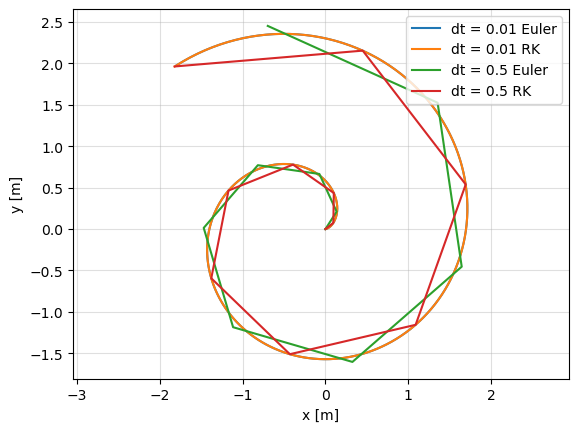

In [100]:
def simulate(dynamics, initial_state, controls, dt):
    state = initial_state
    trajectory = [state]
    time = 0.0

    for u in controls:
        state = dynamics(state, u, time)
        trajectory.append(state)
        time += dt

    return jnp.stack(trajectory)


# code to loop over the different integrators and step sizes
# and plot the corresponding trajectories

initial_state = jnp.array([0.0, 0.0, 0.0, 0.0])
control = jnp.array([2.0, 1.0])  # constant control over the 5 second duration.
duration = 5.0
dts = [0.01, 0.5]

for dt in dts:
    num_steps = int(duration / dt)
    controls = [control] * num_steps
    
    # construct the discrete dynamics for given timestep
    discrete_dynamics_euler = Dynamics(
        euler_integrate(continuous_dynamics, dt), state_dim, control_dim
    )
    discrete_dynamics_rk = Dynamics(
        runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
    )
    
    # simulate dynamics
    xs_euler = simulate(discrete_dynamics_euler, initial_state, controls, dt)
    xs_rk = simulate(discrete_dynamics_rk, initial_state, controls, dt)

    # plot the trajectories
    plt.plot(xs_euler[:, 0], xs_euler[:, 1], label=f"dt = {dt} Euler")
    plt.plot(xs_rk[:, 0], xs_rk[:, 1], label=f"dt = {dt} RK")
    plt.legend()
    
plt.grid(alpha=0.4)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")


### (d) `jax.vmap` 
Suppose now that you want to simulate *many* trajectories. Rather than wrapping the `simulate` function in a for loop, we can use `jax.vmap` which is a *vectorize map* function, allowing us to apply a function, in this case `simulate` over multiple inputs.

An example usage of how to use the `jax.vmap` is shown below. Notice that we can specify which argument should be vectorized and along which dimension.

In [101]:
def foo(x, y, z):
    return x + y + z

N = 1000
x = jnp.array(np.random.randn(N))
y = jnp.array(np.random.randn(N))
z = jnp.array(np.random.randn(N))

xs = jnp.array(np.random.randn(N, N))
ys = jnp.array(np.random.randn(N, N))
zs = jnp.array(np.random.randn(N, N))

foo(x, y, z)  # non-vectorized version
# vectorized version for all inputs, 0 is the batch dimension for all inputs
jax.vmap(foo, in_axes=[0, 0, 0])(xs, ys, zs)  

# x not batched, but ys and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, 0, 0])(x, ys, zs)  

# y not batched, but xs and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, None, 0])(xs, y, zs)  

# z not batched, but xs and ys are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, 0, None])(xs, ys, z)  

# x and y not batched, but zs is with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, None, 0])(x, y, zs)  

# vectorized version for all inputs, batch dimension for xs is 1, 
# while 0 is the batch dimension for yx and zs
jax.vmap(foo, in_axes=[1, 0, 0])(xs, ys, zs)  



Array([[ 0.9569801 , -1.5817823 , -0.81600237, ...,  2.487012  ,
        -0.42623138, -0.638889  ],
       [-0.85308146, -1.3268166 , -1.6453881 , ...,  0.00684825,
         1.4808345 ,  1.847674  ],
       [-0.5760284 , -0.6243871 , -1.9053861 , ...,  0.9835814 ,
        -2.60397   , -4.31215   ],
       ...,
       [ 0.9887279 ,  0.58871734,  0.14252383, ...,  1.2063209 ,
        -0.7999929 , -0.0774948 ],
       [-0.5115725 , -0.96177393,  1.0148453 , ..., -1.8621349 ,
         0.2213524 ,  1.8031802 ],
       [-2.7206619 , -0.71544254, -0.32636118, ..., -0.23614782,
        -0.12503791,  0.11888716]], dtype=float32)

Apply `jax.vmap` for the simulate function for the following batch of initial states and control inputs
Choose $\Delta t = 0.1$.
Use the following values and simulate multiple trajectories using the `jax.vmap` function.


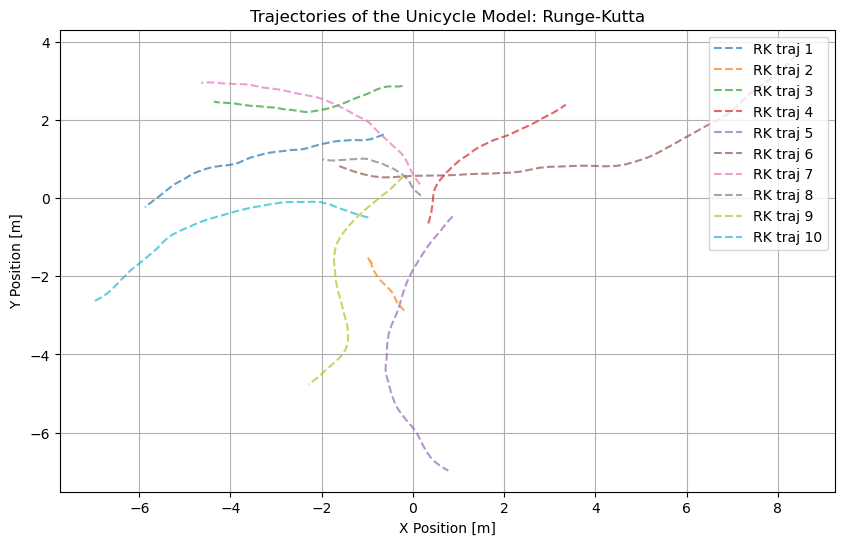

In [102]:
state_dim = continuous_dynamics.state_dim
control_dim = continuous_dynamics.control_dim
N = 1000
n_time_steps = 50
initial_states = jnp.array(np.random.randn(N, state_dim))
controls = jnp.array(np.random.randn(N, n_time_steps, control_dim))



trajs_rk = jax.vmap(lambda init, u: simulate(runge_kutta_integrator(continuous_dynamics, 0.1), init, u, 0.1))(initial_states, controls)
trajs_e = jax.vmap(lambda init, u: simulate(euler_integrate(continuous_dynamics, 0.1), init, u, 0.1))(initial_states, controls)

# plot to visualize all the trajectories

# Extract x and y positions from the trajectories for visualization
x_rk = trajs_rk[:, :, 0]        # x positions for RK trajectories
y_rk = trajs_rk[:, :, 1]        # y positions for RK trajectories
x_e = trajs_e[:, :, 0]        # x positions for Euler trajectories
y_e = trajs_e[:, :, 1]        # y positions for Euler trajectories

# -------------------------------------------------------------------
# Plotting the trajectories for visualization
# -------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot the first 10 trajectories for Runge-Kutta integration
for i in range(min(10, N)):
    plt.plot(x_rk[i, :], y_rk[i, :], label=f"RK traj {i+1}", linestyle='--', alpha=0.7)

# Add plot title, labels, legend, and grid
plt.title("Trajectories of the Unicycle Model: Runge-Kutta")
plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()





### (e) `jax.jit` (optional reading)

Bleh! You notice that it takes some time to run it. And if you increased the duration or number of trajectories to simulate, the computation would increase.
If only we could compile the code to help reduce computation time. With JAX, you can! We can use the `jax.jit` function that performs just-in-time compilation. JAX will figure out the expected sizes of the input arrays and allocate memory based on that.

There are number of ways to just `jax.jit`, and it can get a bit tricky as your code becomes more complex. Best to read up the JAX documentation for more information.
But for relatively simple functions, you can usually just apply `jax.jit` without any fuss, and get significant speedup in your code.

Uncomment the following cells to see the computational benefits of `jax.jit`.

In [103]:
# # without jitting
# %timeit jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

In [104]:
# # method 1: directly apply jax.jit over the jax.vmap function
# # need to provide the static_argnums argument to the first argument since that is a function input and not an array input
# sim_jit = jax.jit(jax.vmap(simulate, in_axes=[None, 0, 0, None]), static_argnums=0)
        
# # time the run
# %timeit sim_jit(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

In [105]:
# # method 2: apply jax.jit over the simulate function and then apply jax.vmap
# sim_jit = jax.jit(simulate, static_argnums=0)
# sim_jit_vmap = jax.vmap(sim_jit, in_axes=[None, 0, 0, None])
# %timeit sim_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

In [106]:
# # Method 3: apply jax.jit over the simulate function during function construction and then apply jax.vmap
# @functools.partial(jax.jit, static_argnames=("dynamics"))
# def simulate(dynamics, initial_state, controls, dt):
#     xs = [initial_state]
#     time = 0
#     for u in controls:
#         xs.append(dynamics(xs[-1], u, time))
#         time += dt
#     return jnp.stack(xs)

# sim_jit_vmap = jax.vmap(simulate, in_axes=[None, 0, 0, None])
# %timeit sim_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

## Problem 2

We continue to consider the dynamically-extended unicycle model and investigate a way to linearize the dynamics around any state. 
First, we will perform the linearization analytically, and then leverage modern computation tools which will be incredibly helpful especially if the dynamics are complicated!
We can efficiently compute gradients via automatic differentiation.
JAX is an automatic differentiation library. 

### (a) Linearize dynamics analytically
Linearize the dynamics given in Problem 1 part (a) about a point $(\mathbf{x}_0, \mathbf{u}_0)$. That is, for linearized dynamics of the form $\dot{\mathbf{x}} \approx A\mathbf{x}+ B\mathbf{u} + C$, give expressions for $A$, $B$, and $C$. 

$A=\ldots$

$B=\ldots$

$C=\ldots$

Also code up your analytic expression in `linearize_unicycle_continuous_time_analytic`.

In [107]:
def linearize_unicycle_continuous_time_analytic(state, control, time):
    '''
    Linearizes the continuous time dynamics of the dynamic unicyle using analytic expression
    Inputs:
        state     : A jax.numpy array of size (n,)
        control   : A jax.numpy array of size (m,)
        time      : A real scalar

    Outputs:
        A : A jax.numpy array of size (n,n)
        B : A jax.numpy array of size (n,m)
        C : A jax.numpy array of size (n,1)
    '''
 # Get vals from state
    theta = state[2]
    v = state[3]

    A = jnp.array([
        [0, 0, -v *jnp.sin(theta), jnp.cos(theta)], #wrt xdot
        [0, 0, v *jnp.cos(theta), jnp.sin(theta)], #wrt ydot
        [0, 0, 0, 0], #wrt omega
        [0, 0, 0, 0] #wrt accel
    ])  #cols wrp x, y, theta, v


    B = jnp.array([
        [0, 0], #wrt xdor
        [0, 0], #wrt ydot
        [1, 0], #wrt omega
        [0, 1] #wrt accel
    ]) #cols wrt omega, accel

    f = dynamic_unicycle_ode(state, control, time)# this function comes from exercise (a) problem 1
    C = f-A @ state - B@ control
    C = C.reshape((4,1))
    return A, B, C

### (b) Evaluate linearized dynamics (analytic)
Using your answer from 2(a), evaluate $A$, $B$, and $C$ for $\mathbf{x}_0 = [0, 0, \frac{\pi}{4}, 2.]^T$ and $\mathbf{u}_0 = [0.1, 1.]^T$. Give your answer to 2 decimal places.

In [108]:
x0 = np.transpose([0, 0, math.pi/4, 2])
u0 = np.transpose([0.1,1.])
time = 0.0
A,B,C = linearize_unicycle_continuous_time_analytic(x0, u0, time)
print("A =", jnp.round(A,2))
print("B =", jnp.round(B,2))
print("C =", jnp.round(C, 2))

A = [[ 0.    0.   -1.41  0.71]
 [ 0.    0.    1.41  0.71]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
B = [[0 0]
 [0 0]
 [1 0]
 [0 1]]
C = [[ 1.11]
 [-1.11]
 [ 0.  ]
 [ 0.  ]]


### (c) Linearize dynamics using JAX autodiff
Time to test out Jax's autodifferentiation capabilities! JAX has an [Autodiff Cookbook](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html) that provides more details about the various autodiff functions, forward vs backward autodiff, jacboians, hessians, and so forth. You are strongly encouraged read through it.

Using Jax and its built-in `jax.jacobian` function, fill in the `linearize_autodiff` function that takes in a dynamics function, and a state and control to linearize about, and returns the $A$, $B$, and $C$ matrices describing the linearized dynamics. Test your function using the continuous-time dynamics with $\mathbf{x}_0 = [0.0, 0.0, \frac{\pi}{4}, 2.0]^T$ and $\mathbf{u}_0 = [0.1, 1.0]^T$ and use the provided test code to verify that the outputs you get from your function are the same as the values you get from `linearize_unicycle_continuous_time_analytic`.

Side note for the curious: the `jnp.allclose` function tests if all corresponding elements of two arrays are within a small tolerance of each other. When working with finite-precision machine arithmetic, you can almost never test two numbers for exact equality directly, because different rounding errors in different computations very often result in very slightly different values even when the two calculations should theoretically result in the same number. For this reason, real numbers in software (which on almost all modern hardware are represented in [IEEE 754 floating-point format](https://en.wikipedia.org/wiki/IEEE_754)) are usually considered to be equal if they are close enough that their difference could be reasonably explained by rounding errors.

In [123]:
def linearize_autodiff(function_name, state, control, time):
    '''
    Linearizes the any dynamics using jax autodiff.
    Inputs:
        function_name: name of function to be linearized. Takes state, control, and time as inputs.
        state     : A jax.numpy array of size (n,); the state to linearize about
        control   : A jax.numpy array of size (m,); the control to linearize about
        time      : A real scalar; the time to linearize about

    Outputs:
        A : A jax.numpy array of size (n,n)
        B : A jax.numpy array of size (n,m)
        C : A jax.numpy array of size (n,1)
    '''
    def dynamics_state(x):
        return function_name(x, control, time)
    def dynamics_control(u):
        return function_name(state, u, time)
    
    A = jax.jacobian(dynamics_state)(state)
    B = jax.jacobian(dynamics_control)(control)
    f0 = function_name(state, control, time)
    C = (f0 - A @ state - B @ control).reshape(-1, 1)

    return A, B, C

        

In [110]:
# test code:
state = jnp.array([0.0, 0.0, jnp.pi/4, 2.])
control = jnp.array([0.1, 1.])
time = 0.0

A_autodiff, B_autodiff, C_autodiff = linearize_autodiff(continuous_dynamics, state, control, time)
A_analytic, B_analytic, C_analytic = linearize_unicycle_continuous_time_analytic(state, control, time)

print('A matrices match:', jnp.allclose(A_autodiff, A_analytic))
print('B matrices match:', jnp.allclose(B_autodiff, B_analytic))
print('C matrices match:', jnp.allclose(C_autodiff, C_analytic))

A matrices match: True
B matrices match: True
C matrices match: True


### (d) Linearize discrete-time dynamics
Assuming your answer from 2(c) matched 2(b) and that you are convinced of the power of automatic differentiation, use your `linearize_autodiff` function on `discrete_dynamics_euler` and `discrete_dynamics_rk` with $\mathbf{x}_0 = [0.0, 0.0, \frac{\pi}{4}, 2.0]^T$ and $\mathbf{u}_0 = [0.1, 1.0]^T$. (Imagine trying to differentiate the expressions analytically! It would be tedious!)

Let $\Delta t=0.1$.

In [136]:
x0 = jnp.array([0.0, 0.0, jnp.pi/4, 2.0])
u0 = jnp.array([0.1, 1.])
dt = 0.1

A_r, B_r, C_r = linearize_autodiff(discrete_dynamics_rk, x0, u0, dt)
#ARK_analytic, BRK_analytic, CRK_analytic = linearize_unicycle_continuous_time_analytic(x0, u0, dt)
A_e, B_e, C_e = linearize_autodiff(discrete_dynamics_euler, x0, u0, dt)
#AE_analytic, BE_analytic, CE_analytic = linearize_unicycle_continuous_time_analytic(x0, u0, dt)


print("A_euler =\n", jnp.round(A_e, 2))
print("B_euler =\n", jnp.round(B_e, 2))
print("C_euler =\n", jnp.round(C_e, 2))
print("A_rk =\n", jnp.round(A_r, 2))
print("B_rk =\n", jnp.round(B_r, 2))
print("C_rk =\n", jnp.round(C_r, 2))

A_euler =
 [[ 1.    0.   -0.14  0.07]
 [ 0.    1.    0.14  0.07]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
B_euler =
 [[0.         0.        ]
 [0.         0.        ]
 [0.09999999 0.        ]
 [0.         0.09999999]]
C_euler =
 [[ 0.11]
 [-0.11]
 [-0.  ]
 [-0.  ]]
A_rk =
 [[ 1.          0.         -0.14999999  0.07      ]
 [ 0.          1.          0.14        0.07      ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
B_rk =
 [[-0.01        0.        ]
 [ 0.01        0.        ]
 [ 0.09999999  0.        ]
 [ 0.          0.09999999]]
C_rk =
 [[ 0.12]
 [-0.11]
 [-0.  ]
 [-0.  ]]


### (e) Applying `vmap` to linearize over multiple points
Now, try to linearize your dynamics over multiple state-control values using `vmap`!


A linearized has shape: (1000, 4, 4)
B linearized has shape: (1000, 4, 2)
C linearized has shape: (1000, 4, 1)


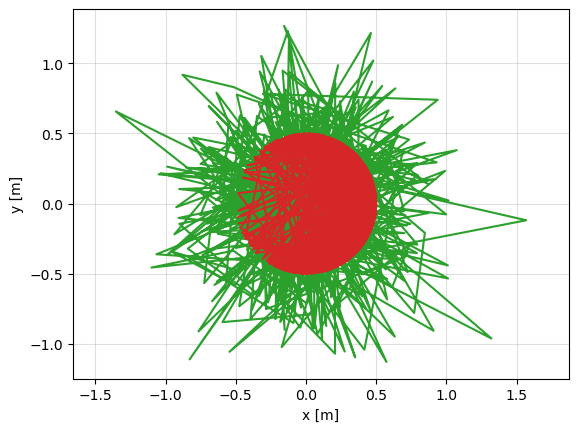

In [112]:
key = jax.random.PRNGKey(42)  # Set a fixed seed
n_samples = 1000
state_dim = 4  # 4-dimensional state
ctrl_dim = 2  # 2-dimensional control

time = 0.0
random_states = jax.random.normal(key, shape=(n_samples, state_dim))
random_controls = jax.random.normal(key, shape=(n_samples, ctrl_dim))

trajs = jax.vmap(lambda init, u: linearize_autodiff(discrete_dynamics_rk, init, u, 0.1))(random_states, random_controls)

plt.plot(trajs[0][:, 0], trajs[0][:, 1])
plt.grid(alpha=0.4)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

print("A linearized has shape:",trajs[0].shape)
print("B linearized has shape:",trajs[1].shape)
print("C linearized has shape:",trajs[2].shape)


## Problem 3 Unconstrained optimization
The goal of this problem is to introduce some basic optimization theory and understanding how automatic differentition can be used for solving unconstrained optimization problems (and essentially powering deep learning libraries under the hood).

In this problem, we will implement a simple version of the gradient descent algorithm to solve an unconstrained optimization problem. Specifically, you will learn about the log-barrier method which is used to cast a _constrained_ optimization problem into an unconstrained one which can be easily solved using gradient descent.


### Some background on optimization
In mathematics, _optimization_ is the process of finding which value of an argument to a function makes the output of that function as high or as low as possible. In other words, given a function $f(x)$ (called the _cost function_ or _objective function_), which value of $x$ makes $f(x)$ as high (or as low) as possible? 

In controls, we often consider the objective as a *cost* function (e.g., total fuel or control effort, distance traveled) and thus aim to make $f(x)$ as _low_ as possible; in other words, we often only consider the problem of minimizing $f(x)$. While in reinforcement learning, typically the objective is viewed as a *reward*, and therefore the aim is to maximize $f(x)$. But note that this is just the same thing as minimizing $-f(x)$, so maximization and minimization actually turn out to be basically the same mathematical problem, but the convention depends on the community.

Optimization is very useful in engineering; for example, if $x$ is a variable that somehow represents the design of an airplane (maybe it's a vector of design parameters such as wing aspect ratio, engine thrust, cargo space, etc), and if we can find a function $f(x)$ that computes the fuel consumption of the final airplane as a function of the design parameters, than finding $x$ which minimizes $f(x)$ amounts to designing the most fuel-efficient airplane possible under the design assumptions. We often denote the value of $x$ which optimizes $f(x)$ as $x^*$, and the optimal value of $f(x)$ is then $f(x^*)$.

You may remember from undergrad calculus that we can minimize $f(x)$ by taking its derivative $f'(x)$, setting $f'(x^*) = 0$, and solving for $^*x$. If $f(x)$ is scalar-valued but has a vector-valued input, we would generalize this to taking the _gradient_ $\nabla f(x)$, setting to zero, and solving for $x^*$. However, in many practical applications $\nabla f(x)$ is far too complicated to solve $\nabla f(x^*) = 0$ analytically; just think how complicated our fuel consumption function in the example above would be. Thus, in practice we often use iterative numerical optimization algorithms such as _gradient descent_.

Gradient descent (for a scalar function of a single scalar argument) works as follows. First, assume some initial guess $x_0$. Then, iteratively improve successive guesses $x_k$ like so:

$$
x_{k+1} = x_k - \alpha \nabla f(x_k),
$$

where $\alpha$ is some small positive fixed "step size" parameter which we choose. This has the effect of moving our successive guesses "down the hill" of the function $f(x)$. This process is repeated until successive iterates converge to some specified convergence tolerance $\epsilon$:

$$
\left\lvert x_{k+1} - x_k \right\rvert < \epsilon \implies \text{stop iterating.}
$$

The final $x$ iterate we take to be our optimal $x^*$.

You may notice that your solution, or whether you may converge, depends on your choice of step size. There are techniques to choose and adapt the step size. We won't discuss this further in the course, but [ADAM](https://arxiv.org/abs/1412.6980) is a popular approach.



### (a) Gradient descent on unconstrained optimization problem
Consider the objective function $f(x) = (x + 2)^2 + 5\tanh (x)$, defined in code and plotted below. The value of $x$ which minimizes $f(x)$ is $x^* = -2.13578$, and $f(x^*) = -4.84389$. In the next code cell, fill out the `minimize_with_gradient_descent` function; you can use Jax's autodiff capabilities to compute $f'(x)$. The starter code in that cell will use your gradient descent function with an initial guess of $x = 5$, a step size of $0.1$, and a convergence tolerance of $10^{-8}$ to minimize $f(x)$; verify that your algorithm does indeed find the correct minimizing $x^*$ and minimal value $f(x^*)$.

Fun fact: with $f(x) = (x + 2)^2 + 5\tanh (x)$, then $f'(x)$ is a transcendental function, and $f'(x) = 0$ _can't_ be solved algebraically. If your gradient descent code worked, congratulations! You've written code that numerically solved a math problem in milliseconds that can't be solved analytically at all.

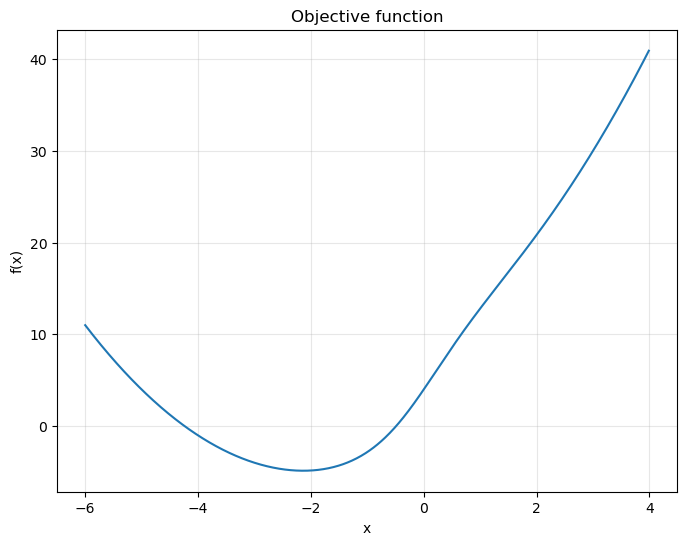

In [113]:
def f(x):
    return (x + 2)**2 + 5*jnp.tanh(x)

args = np.arange(-6,4,0.01)
plt.figure(figsize=(8,6))
plt.plot(args, f(args))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Objective function')
plt.grid(alpha=0.3)
plt.show()

optimal x: -2.135782
optimal value of f(x): -4.8438854


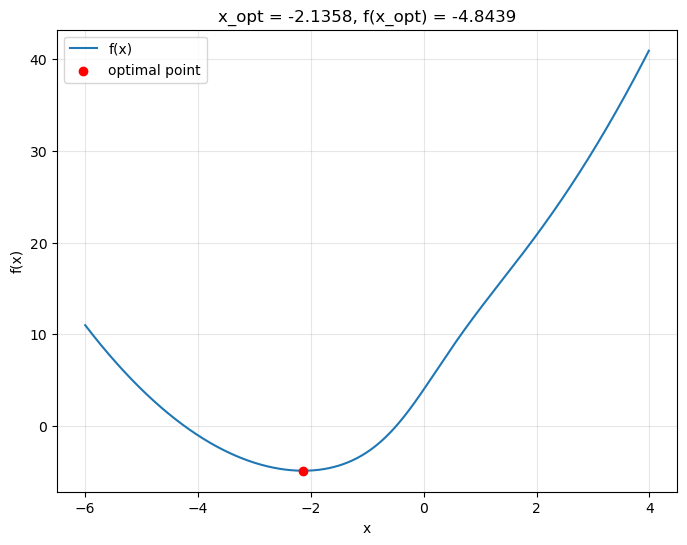

In [114]:
def minimize_with_gradient_descent(func, initial_guess, step_size, convergence_tol=1e-8):
    '''
    Minimizes a scalar function of a single variable.
    Inputs:
        func              : name of function to be optimized. Takes initial_guess as input.
        initial_guess     : a real number
        convergence_tol   : convergence tolerace; when current and next guesses of of optimal x are closer
                            together than this, algorithm terminates and returns current estimate of optimal x

    Outputs:
        cur_x : current best estimate of x which minimizes f(x)
    '''
    
    next_x = cur_x = initial_guess  #init 
    current_tol = convergence_tol
    deriv_func = grad(func)
    while current_tol >= convergence_tol:
        
        next_x = cur_x - step_size * deriv_func(cur_x)
        current_tol = abs(cur_x - next_x) # calculate new tol
        cur_x = next_x # update curr

    return cur_x
        
x_opt = minimize_with_gradient_descent(f, 5.0, 0.1)


# output and plot:
print('optimal x:', x_opt)
print('optimal value of f(x):', f(x_opt))

args = np.arange(-6,4,0.01)
plt.figure(figsize=(8,6))
plt.plot(args, f(args), label='f(x)')
plt.scatter(x_opt, f(x_opt), zorder=2, color='red', label='optimal point')
plt.title('x_opt = {:.4f}, f(x_opt) = {:.4f}'.format(x_opt, f(x_opt)))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


### (b) Applying log-barrier for solving constrained optimization problems
Now suppose we want to add a _constraint_ to our optimization problem; that is, a restriction on the set of $x$ values we'll consider acceptable. In particular, in this case we'll say that we only want values of $x$ such that, for some specified _constraint function_ $g(x)$, we have $g(x) < 0$; this is called an _inequality constraint_.

The gradient descent algorithm described above has no way to enforce a constraint like this; $x$ is allowed to wander wherever the gradient takes it. Thus we must modify the algorithm to allow it to find constrained optima under inequality constraints. There are several ways to do this, but in this problem we will be using the _log-barrier method_. 

In this method, we construct from the objective function $f(x)$ a different objective function $\phi (x)$ that has the following properties:
 - When $x$ is such that $g(x)$ is far away from $0$, then $\phi(x)$ must approximate $f(x)$, so that minimizing $\phi(x)$ approximately minimizes $f(x)$.
 - $\phi(x)$ must grow to infinity as $g(x)$ approaces $0$. This will prevent $x$ from crossing over the boundary of $g(x) < 0$.

To accomplish these goals, we construct $\phi(x)$ like so:
$$
\phi(x) = f(x) - t\ln(-g(x)),
$$
where $t$ is a weighting parameter that we choose.

Suppose we want to minimize the same objective function as before, $f(x) = (x + 2)^2 + 5\tanh (x)$, but now we want a constraint $x > 1$. In the code block below, fill out the functions `g` and `phi`. The starter code will plot $f(x)$, as well as $\phi(x)$ for $t = 0.5,\ 2,\ 5$. Comment on how $\phi(x)$ changes with changing $t$. Note that since $\ln(y)$ is not defined (in the real numbers) for $y \le 0$, the domain of $\phi(x)$ is restricted to $x > 1$.

Hint: for your `phi` function to work well with the next parts of this problem, be sure to use `jnp.log` instead of `np.log`.

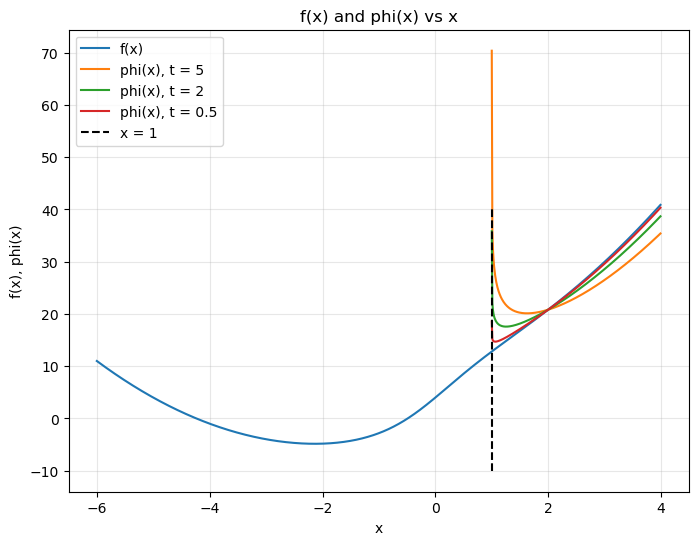

In [115]:
# fill out g(x) so that the statement g(x) < 0 is equivalent to the statement x > 1
def g(x):
    return 1 - x

def phi(f, x, g, t):
    '''
    Computes phi(x).
    Inputs:
        f  : name of f(x) function; takes x as input
        x  : variable to be optimized
        g  : constraint function; we want to ensure g(x) <= 0
        t  : log-barrier weighting parameter

    Outputs:
        phi(x)
    '''
    
    phi_x = f(x) - t*jnp.log(-g(x))

    return phi_x


x_upper = 4
dx = 0.01
f_x_domain = np.arange(-6, x_upper, dx)
phi_x_domain = np.arange(1.00001, x_upper, dx)

plt.figure(figsize=(8,6))
plt.plot(f_x_domain, f(f_x_domain), label='f(x)')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 5), label='phi(x), t = 5')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 2), label='phi(x), t = 2')
plt.plot(phi_x_domain, phi(f, phi_x_domain, g, 0.5), label='phi(x), t = 0.5')
plt.vlines(1, -10, 40, linestyles='dashed', label='x = 1', color='black')
plt.xlabel('x')
plt.grid(alpha=0.3)
plt.ylabel('f(x), phi(x)')
plt.title('f(x) and phi(x) vs x')
plt.legend(loc='upper left')
# plt.ylim(-10, 40)
plt.show()


### (c)
Now, we can use our `minimize_with_gradient_descent` function to minimize $\phi(x)$ instead of $f(x)$. Do so below, for a few different values of $t$, and comment on the results. The true constrained optimal point is $x^* = 1$, $f(x^*) = 12.808$. 

- Does the log-barrier method find the true constrained optimal point? 
<span style="color:red">The lower the barrier weight, the closer we get to the barrier. However, if the step size isnt sufficently small, the barrier could be passed and the program will run indefinitely, unable to return to the safe area.</span>

- How does the point found by the log-barrier method change as you change $t$? 
<span style="color:red">As t decreases, the point found by the log-barrier method will get closer and closer to the boundary.That is why, as you stated, a small t-value needs a small step-size, as there is greater risk of passing the barrier. High t-values are less risky of passing the barrier, and in term are less accurate/farther away from the barrier, if that is where the true value lies.</span>


You may find that as you decrease $t$, you also need to decrease the gradient descent step size to get good behavior (in particular, to avoid "overshooting" the constraint and finding an $x^*$ estimate which does not respect the constraint). Also, for the log-barrier method to work, your initial guess must itself respect the constraint (in this case, your initial guess must be greater than one).

Hint: the `minimize_with_gradient_descent` function requires an objective function that takes only $x$ as an argument: $f(x)$. But our `phi` Python function defined above takes `f`, `x`, `g`, and `t`; you may find Python's "lambda function" capabilities useful or the `functools.partial`.

In [116]:
# ========================== hint: lambdas ==============================

def hint_func(arg1, arg2, arg3):
    return arg1 + 2 * arg2 + arg3

def hint_func_caller(func, arg):
    return func(arg)

foo = 42
bar = 100

lambda x: hint_func(foo, x, bar) # this essentially defines a function of x only, that calls hint_func(x, 42, 100)

# hint_func_caller expects a function that takes only one argument. But we can use a lambda expression to
# "prepopulate" all but one argument of hint_func, "turning it into" an argument of one function:

hint_func_caller(lambda x: hint_func(foo, x, bar), 5) # this will work and give 152

# ^^^^^^^^^^^^^^^^^^^^^^^^^^ hint: lambdas ^^^^^^^^^^^^^^^^^^^^^^^^^^

# ========================== hint: functools.partial ==============================

new_func = functools.partial(hint_func, foo, arg3=bar) # this is equivalent to lambda x: hint_func(foo, x, bar)
new_func(5) # this will give 152

# OR

new_func = functools.partial(hint_func, arg1=foo, arg3=bar) # this is equivalent to lambda x: hint_func(foo, x, bar)
new_func(arg2=5) # this will give 152

# ^^^^^^^^^^^^^^^^^^^^^^^^^^ hint: functools.partial ^^^^^^^^^^^^^^^^^^^^^^^^^^

# f, x, g, t
x = 5.0
t = .001 #barrier weight
step_size = .001
#new_func = functools.partial(minimize_with_gradient_descent, func=f, initial_guess=x) # this is equivalent to lambda x: hint_func(foo, x, bar)
#print(new_func(step_size=t)) 

new_phi = lambda x: phi(f, x, g, t)
xbar_opt = minimize_with_gradient_descent(new_phi, initial_guess= x, step_size=step_size)
print(xbar_opt, f(xbar_opt))





-2.1358607 -4.8438864


## Problem 4 (`cvxpy`)

In this problem we will explore the basics of `cvxpy`, a Python package for solving convex optimization problems. `cvxpy` has a good tutorial [here](https://www.cvxpy.org/tutorial/intro/index.html), so read that page before proceeding with this problem (the section on "parameters", while useful, is not important for this homework, so consider that section optional for now).


Consider a vector variable $x = [x_1,  x_2,  x_3]^T$. Use `cvxpy` to compute the minimizer of the following objective function
$$
x_1^2 + 2x_2^2 + 3.5x_3^2,
$$

subject to the constraint

$$
\begin{bmatrix}
0.707 & 0.707 & 0 \\
-1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & -1
\end{bmatrix}x \le \begin{bmatrix}
2 \\
-1 \\
-1 \\
-3
\end{bmatrix}.
$$

Print the optimal $x$ and the optimal value of the objective function.

Notice how much easier it is to use `cvxpy` than to write our own optimization algorithm from scratch!

In [117]:
A = np.array([
    [0.707, 0.707, 0],
    [-1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
    ])

b = np.array([2, -1, -1, -3])
X = cp.Variable(3)

constraints = [A @ X <= b]

# Minimizes objective function within Problem
prob = cp.Problem(cp.Minimize(X[0]**2 + 2 * X[1]**2 + 3.5 * X[2]**2), constraints)
prob.solve()
print(X.value, prob.value)

[1. 1. 3.] 34.5


## Problem 5 (Control Barrier Function and CBF-QP)

In this problem, using the concepts and code you have developed in the previous problems, you will implement a CBF-QP safety filter.
We will restrict ourselves to a simple 1D system so that you can verify your results analytically if needed, but note that the theory extends to higher dimensional problems, and try to keep your code general so that it could still work on a different system and choice of CBF.

Consider the following 1D single integator dynamics $ \dot{x} = u $ and let $b(x) = x^2 - 1$.

### (a) Computing the Lie derivative
What is the expression for $\nabla b(x)^T f(x,u)$?

$\nabla b(x) = 2x$ 

$f(x,u) = u$

$\nabla b(x)^Tf(x,u) = 2x * u$

### (b) Solving the CBF-QP
Suppose that your desired control is $u_\mathrm{des}=0.5$, which is to move in the positive $x$-direction at constant velocity. But the safety filter enforces that $x^2 \geq 1$, i.e., keep a 1 unit away from the origin.

The CBF safety filter essentially chooses a control input that is as close to $u_\mathrm{des}$ as possible while satisfying the CBF inequality constraint.

$$
u_\mathrm{safe}(x) = \underset{u}{\text{argmax}} \| u - u_\mathrm{des}\|_2^2 \:\: \text{subj. to} \:\: \nabla b(x)^Tf(x,u) \geq -\alpha(b(x))
$$

This is referred to as the CBF-QP since it is a quadratic program (quadratic objective and linear constraints). For simplicity, we assume there are no other constraints on controls.

Let $\alpha(z) = az$, $a=0.5$
Use `cvxpy` to solve the CBF-QP for $x=-3$, $x=-2$ and $x=-1.1$.

Report the corresponding safe control values.

Hint: You may find the `Parameter` variable in `cvxpy` helpful. It allows you to update certain parameters without needing to reconstruct the optimization each time.




In [118]:
x = cp.Parameter(nonpos = True)
u = cp.Variable()

u_des = 0.5
a = 0.5 #constraint decentivization 

b = lambda x_val: x_val**2 - 1 #b(x) equation
alpha_func = lambda b_val: a * b_val

constraint = [2 * x * u >= -alpha_func(b(x))]

prob = cp.Problem(cp.Minimize((u - u_des)**2), constraint)

x_vals = [-3, -2, -1.1]

for ele in x_vals:
    x.value = ele
    prob.solve()
    print(x.value, u.value, prob.value)

-3 0.5000000000000001 1.232595164407831e-32
-2 0.375 0.015625
-1.1 0.047727272727272764 0.20455061983471068


c:\Users\ariel\anaconda3\envs\ME548\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


### (c) Applying the CBF safety filter
Now, simulate the system starting from $x=-5$ and with $u_\mathrm{des}=0.5$, but the CBF safety filter is applied. Plot the state and control sequence for $a=2$, $a=1$, $a=0.5$ and $a=0.1$ where $\alpha(z) = az$. 
Comment on how the trajectory changes as $a$ changes. What is your interpretation of $a$?



<span style="color:red">It appears that the larger "a" is, the more agressive the filter is. With higher a values, the change in the control value is sharper and the state values beeline toward the safe region. Higher a values mean the system will prioritize moving toward the safe region versus the desired input.</span>

Use $\Delta t = 0.05$ and simulate for 500 steps.

Note that the CBF theory is for continuous-time dynamics, but when we simulate, we use discrete-time dynamics. There are some practical issues that we need to be careful about (see [this paper](https://arxiv.org/abs/2404.12329) for more details), but right now, let's stick to using a reasonably small time step.



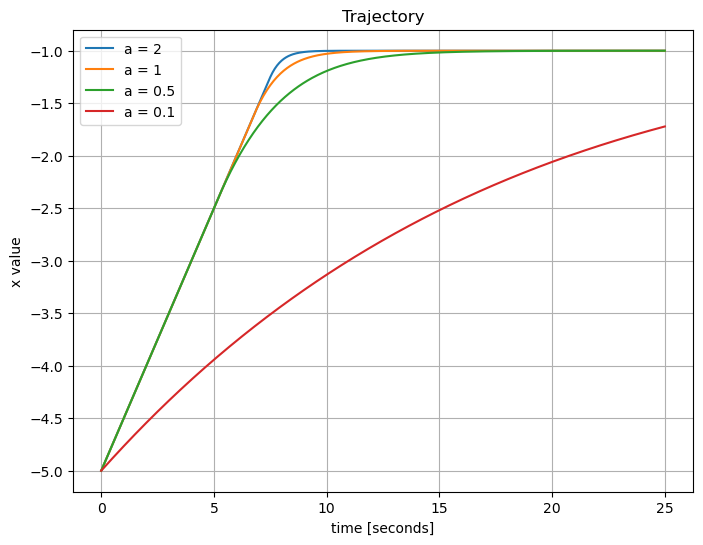

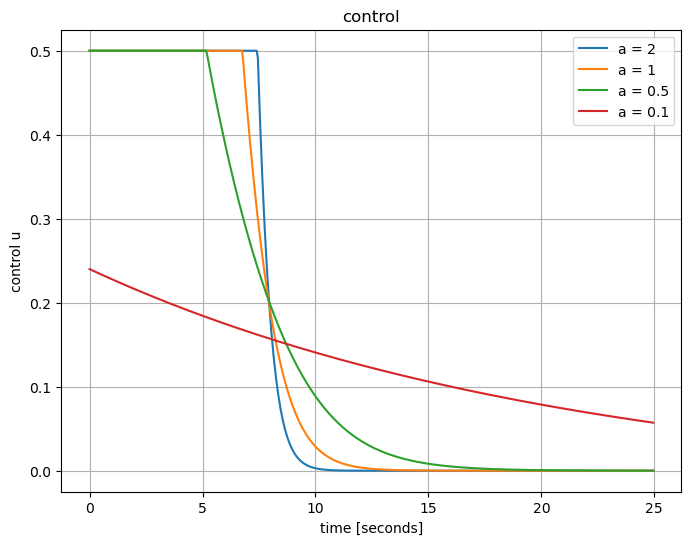

In [119]:
u_des = .5
dt = 0.05
steps = 500
x0 = -5
a_vals = [2, 1, 0.5, 0.1]
trajs = {} #dictionary


for a in a_vals:
    x_param = cp.Parameter(nonpos=True)  # x must be nonpositive for CBF
    u = cp.Variable()

    x_vals = [x0]
    u_vals = []

    for i in range(steps):
        x_param = cp.Parameter(nonpos=True)
        u = cp.Variable()

        # iterate through the x_vals 
        x_val = x_vals[-1]
        x_param.value = x_val

        b_func = cp.square(x_param) - 1
        alpha_func = a * b_func
        constraint = [2 * x_param * u >= -alpha_func]

        prob = cp.Problem(cp.Minimize((u - u_des)**2), constraint)
        prob.solve()

        u_val = u.value #store u_vals for 
        u_vals.append(u_val)

        x_next = x_val + dt * u_val #get next x_val, Euler int.
        x_vals.append(x_next)

    trajs[a] = (np.array(x_vals), np.array(u_vals)) #storing/connecting the x_vals and u_vals trajectories to the corresponding a_val

# Plot results
time = np.arange(steps + 1) * dt #time steps 0 through 5.00s

# Plot x(t)
plt.figure(figsize=(8,6))
for a in a_vals:
    plt.plot(time, trajs[a][0], label=f'a = {a}')
    plt.ylabel('x value')
    plt.xlabel('time [seconds]')
    plt.title('Trajectory')
    plt.legend()
    plt.grid(True)
plt.show()


# Plot u(t)
plt.figure(figsize=(8,6))
for a in a_vals:
    plt.plot(time[:-1], trajs[a][1], label=f'a = {a}')
    plt.ylabel('control u')
    plt.xlabel('time [seconds]')
    plt.title('control')
    plt.legend()
    plt.grid(True)
plt.show()


    # simulate system, during which the CBF-QP safety filter is applied.
    # loop over various values of a.



